In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [3]:
df = pd.read_csv("final_merged_df.csv")
df.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,Pop_Density_2014,Pop_Density_2015,Pop_Density_2016,Pop_Density_2017,Pop_Density_2018,Pop_Density_2019,Pop_Density_2020,Wind_Speed,Grid_Value,Income_Distribution
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,17.609232,18.419613,21.129835,26.949865,35.308475,39.717140,52.668011,6.410498,1.0,Turkana
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,15.599761,15.981864,17.861954,23.140518,29.548529,32.403442,42.566807,6.410498,1.0,Turkana
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,14.218251,14.787646,16.177166,21.212101,26.670294,29.277493,39.304050,6.410498,1.0,Turkana
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,14.553508,15.171118,16.479475,22.152906,27.807093,30.655039,41.851067,6.410498,1.0,Turkana
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,13.881150,14.152464,15.410886,20.551128,25.901073,28.307270,38.238289,6.410498,1.0,Turkana


In [4]:
missing_values = df.isnull().sum()
missing_values

Latitude               0
Longitude              0
Pop_Density_2000       0
Pop_Density_2001       0
Pop_Density_2002       0
Pop_Density_2003       0
Pop_Density_2004       0
Pop_Density_2005       0
Pop_Density_2006       0
Pop_Density_2007       0
Pop_Density_2008       0
Pop_Density_2009       0
Pop_Density_2010       0
Pop_Density_2011       0
Pop_Density_2012       0
Pop_Density_2013       0
Pop_Density_2014       0
Pop_Density_2015       0
Pop_Density_2016       0
Pop_Density_2017       0
Pop_Density_2018       0
Pop_Density_2019       0
Pop_Density_2020       0
Wind_Speed             0
Grid_Value             0
Income_Distribution    0
dtype: int64

## **HDBSCAN**

### **Identify regions with sparse development where extending the grid is inefficient but wind microgrids could be feasible.**

* Since HDBSCAN is a density-based algorithm,the clustering approach effectively groups areas based on density and other characteristics.
* These clusters help indicate areas where extending the main grid might be inefficient, making them candidates for decentralized energy solutions, like wind or solar microgrids.
* This algorithm is valuable for identifying potential zones for alternative energy solutions based on current density and infrastructure access patterns.

In [5]:
# One-hot encode 'Income_Distribution' if it's categorical
df = pd.get_dummies(df, columns=['Income_Distribution'], prefix='Income')

#### **Subset Sampling for Exploration**
##### Save subsets of the data to analyze specific portions or store them separately for additional exploration or testing.


In [6]:
n=250000
m = 2500
s = 5012
e = 178934
j = 2500
df_1=df.head(j)
df_2 = df.tail(m)
df_3=df.iloc[s:e]
df_4=df.sample(n=n)

In [7]:
# df_1.to_csv("../first_2500_rows.csv")
# df_2.to_csv("../last_2500_rows.cvs")
# df_3.to_csv("middle_rows.csv")
# df_4.to_csv("random_rows.csv")

In [8]:
# df.to_csv("../test.csv")

### **Data Preparation for Clustering**
Select the relevant columns, including one-hot encoded income columns, for clustering.

In [9]:
# The one-hot encoded columns starting with "Income_"should be included
income_columns = [col for col in df.columns if col.startswith('Income_')]
clustering_data = df[['Pop_Density_2020', 'Wind_Speed', 'Latitude', 'Longitude', 'Grid_Value'] + income_columns]

### **Standardize Features**
Standardize the data to bring all features to a similar scale, ensuring they contribute equally to clustering.


In [10]:
# Standardize the data to bring all features to a similar scale
scaler = StandardScaler()
clustering_data_scaled = scaler.fit_transform(clustering_data)

**Apply PCA for Dimensionality Reduction**

Reduce to 2 components for visualization and efficiency. This helps capture the primary data variance in fewer dimensions.

In [11]:
# Apply PCA to reduce to a manageable number of components
pca = PCA(n_components=2)  # Adjust to 2 components for efficient clustering
clustering_data_reduced = pca.fit_transform(clustering_data_scaled)

Add PCA components back to the DataFrame for easier access during visualization and further analysis


In [12]:
# Add PCA components back to the DataFrame
df['PCA_Component_1'] = clustering_data_reduced[:, 0]
df['PCA_Component_2'] = clustering_data_reduced[:, 1]

### **HDBSCAN Clustering with Initial Parameters**
Initialize and fit the HDBSCAN model with chosen parameters, designed to identify natural clusters in the data.


In [13]:
# HDBSCAN clustering with optimized parameters
hdbscan_clusterer = hdbscan.HDBSCAN(metric='manhattan', min_samples=10, min_cluster_size=50)
clusters = hdbscan_clusterer.fit_predict(clustering_data_reduced)
stability_scores = hdbscan_clusterer.probabilities_

Add clusters and stability scores to the DataFrame

In [14]:
# Add clusters and stability scores back to the original DataFrame
df['Cluster'] = clusters
df['Stability_Score'] = stability_scores

### **Evaluate Clustering Quality**
Calculate clustering metrics for evaluation, excluding noise points labeled as -1.

In [15]:
# Filter out noise points (-1 label in HDBSCAN) before calculating metrics
clustered_data = clustering_data_reduced[clusters != -1]
valid_clusters = clusters[clusters != -1]

In [16]:
if len(set(valid_clusters)) > 1:  # Ensure there's more than one cluster for evaluation
    db_index = davies_bouldin_score(clustered_data, valid_clusters)
    ch_index = calinski_harabasz_score(clustered_data, valid_clusters)
    print("Davies-Bouldin Index:", db_index)
    print("Calinski-Harabasz Index:", ch_index)
else:
    print("Insufficient clusters for evaluation metrics")

# Print stability scores and cluster labels
print("Cluster Labels:", clusters)
print("Cluster Stability Scores:", stability_scores)

Davies-Bouldin Index: 0.6969684556875131
Calinski-Harabasz Index: 410962.8938781065
Cluster Labels: [ 330  330  330 ...  285 1104 1104]
Cluster Stability Scores: [1.         1.         1.         ... 0.04395425 0.87210856 0.87210856]


### **Cluster Visualization**
Visualize the clusters on the two PCA components to understand the data's clustering structure.


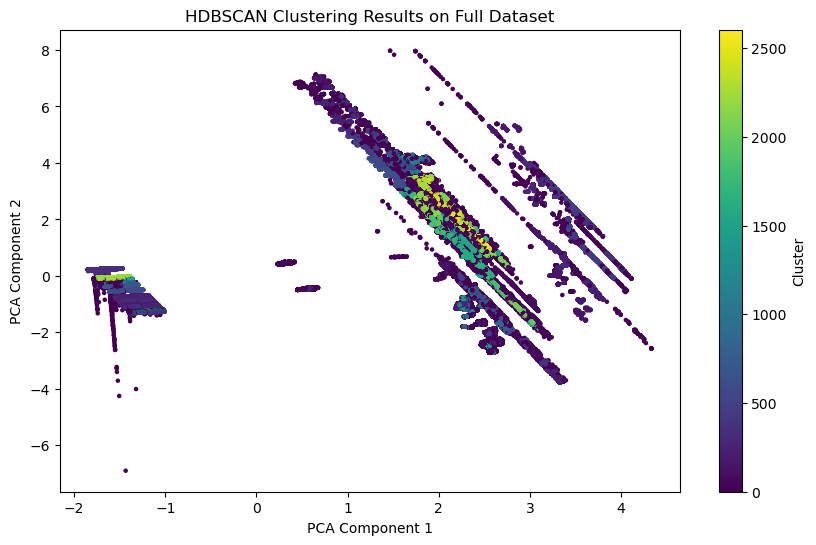

In [17]:
# Visualize clustering results
plt.figure(figsize=(10, 6))
plt.scatter(clustering_data_reduced[:, 0], clustering_data_reduced[:, 1], c=clusters, cmap='viridis', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('HDBSCAN Clustering Results on Full Dataset')
plt.show()

#### **Fine-Tuning with Grid Search**
Explore various combinations of HDBSCAN parameters to optimize clustering performance.


In [18]:
import itertools

In [19]:
# Define parameter grid
min_cluster_sizes = [20, 50, 100]
min_samples_options = [5, 10, 20]
metrics = ['euclidean', 'manhattan']

In [20]:
# Store results
best_params = {}
best_db_index = float('inf')

In [21]:
# for min_cluster_size, min_samples, metric in itertools.product(min_cluster_sizes, min_samples_options, metrics):
#     # Initialize HDBSCAN with current parameters
#     hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric=metric)
#     clusters = hdbscan_clusterer.fit_predict(clustering_data_reduced)
    
#     # Evaluate if there are valid clusters
#     clustered_data = clustering_data_reduced[clusters != -1]
#     valid_clusters = clusters[clusters != -1]
    
#     if len(set(valid_clusters)) > 1:
#         # Calculate Davies-Bouldin Index for current configuration
#         db_index = davies_bouldin_score(clustered_data, valid_clusters)
        
#         # Keep track of best parameters
#         if db_index < best_db_index:
#             best_db_index = db_index
#             best_params = {
#                 'min_cluster_size': min_cluster_size,
#                 'min_samples': min_samples,
#                 'metric': metric,
#                 'db_index': db_index,
#             }

#         # Calculate and print additional metrics for analysis
#         ch_index = calinski_harabasz_score(clustered_data, valid_clusters)
       
#         print(f"Params: min_cluster_size={min_cluster_size}, min_samples={min_samples}, metric={metric}")
#         print(f"Davies-Bouldin Index: {db_index}, Calinski-Harabasz Index: {ch_index}")

# print("Best Parameters:", best_params)

### Lets use the optimal parameters for the HDBSCAN clustering model

* min_cluster_size = 20: This means that the model will only form clusters with at least 20 points, helping to avoid very small, potentially noisy clusters.
* min_samples = 20: Each core point in a cluster needs at least 20 neighbors within the defined metric space (here, Manhattan distance) to be considered a part of the cluster. This parameter helps in controlling the density required to form a cluster.
* metric = 'manhattan': The model uses the Manhattan (or L1) distance, which calculates distance based on the absolute differences in feature values which is more suitable for data with a grid-like or spatial structure, and captures unique patterns in this dataset.

In [22]:
df.head()

,Latitude,Longitude,Pop_Density_2000,Pop_Density_2001,Pop_Density_2002,Pop_Density_2003,Pop_Density_2004,Pop_Density_2005,Pop_Density_2006,Pop_Density_2007,...,Income_Trans Nzoia,Income_Turkana,Income_Uasin Gishu,Income_Vihiga,Income_Wajir,Income_West Pokot,PCA_Component_1,PCA_Component_2,Cluster,Stability_Score
0,35.244583,5.462084,1.416720,1.396852,1.624173,1.924415,2.429911,2.503574,3.391726,3.823526,...,False,True,False,False,False,False,-1.472061,0.266045,330,1.0
1,35.252917,5.462084,1.413419,1.372664,1.583961,1.867518,2.361063,2.378553,3.223956,3.587913,...,False,True,False,False,False,False,-1.472296,0.266436,330,1.0
2,35.261250,5.462084,1.418887,1.330445,1.540141,1.809350,2.250990,2.280811,3.042585,3.314642,...,False,True,False,False,False,False,-1.472524,0.266547,330,1.0
3,35.269583,5.462084,1.457395,1.385305,1.572818,1.860333,2.281828,2.322971,3.142808,3.381774,...,False,True,False,False,False,False,-1.472746,0.266421,330,1.0
4,35.277917,5.462084,1.512301,1.383120,1.565848,1.837749,2.219377,2.283923,3.029301,3.247593,...,False,True,False,False,False,False,-1.472974,0.266547,330,1.0


In [23]:
# Apply HDBSCAN with optimal parameters
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=20, metric='manhattan')
clusters = hdbscan_clusterer.fit_predict(clustering_data_reduced)
stability_scores = hdbscan_clusterer.probabilities_

In [24]:
# Add clusters and stability scores to the DataFrame
df['Cluster'] = clusters
df['Stability_Score'] = stability_scores

In [25]:
# Filter out noise points for evaluation metrics
clustered_data = clustering_data_reduced[clusters != -1]
valid_clusters = clusters[clusters != -1]

In [26]:
# Calculate evaluation metrics if there are valid clusters
if len(set(valid_clusters)) > 1:
    db_index = davies_bouldin_score(clustered_data, valid_clusters)
    ch_index = calinski_harabasz_score(clustered_data, valid_clusters)
    print("Optimal Davies-Bouldin Index:", db_index)
    print("Optimal Calinski-Harabasz Index:", ch_index)
else:
    print("Insufficient clusters for evaluation metrics")

Optimal Davies-Bouldin Index: 0.5085943800885435
Optimal Calinski-Harabasz Index: 539123.966920015


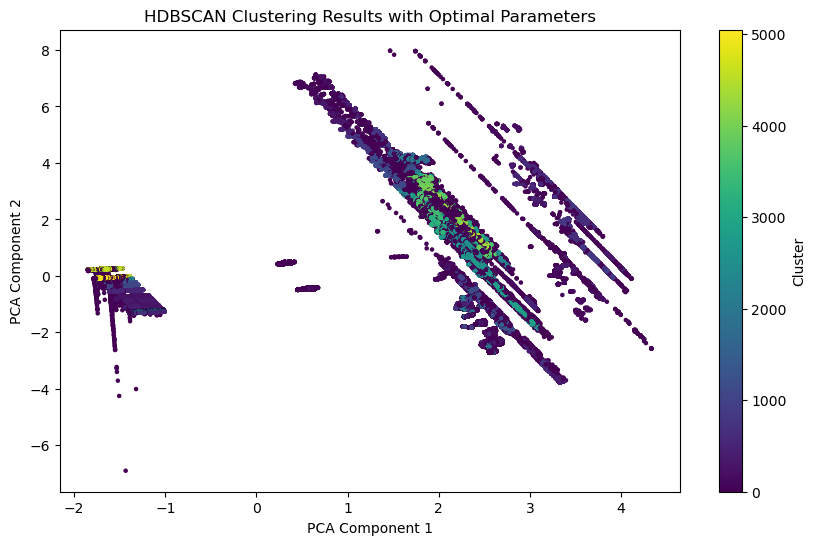

In [27]:
# Visualization of clustering results
plt.figure(figsize=(10, 6))
plt.scatter(df['PCA_Component_1'], df['PCA_Component_2'], c=clusters, cmap='viridis', s=5)
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('HDBSCAN Clustering Results with Optimal Parameters')
plt.show()

### Findings
* The visualization reveals distinct groupings of points based on the PCA-reduced data. Clusters appear compact and separated, which aligns with the favorable DBI score. This implies that the areas in the dataset are grouped into well-defined regions based on density.
* Some points are scattered and appear isolated from any cluster in the visualization, likely labeled as noise (-1). These noise points are considered outliers by HDBSCAN. In the context of our project (Energy Access and Electrification Planning in Kenya), these points might represent regions with atypical characteristics where extending the grid or establishing microgrids could be inefficient.
* Many clusters appear elongated or linear, which could imply correlations between features in the data. This linear structure indicates that certain features (e.g., population density, grid values) might be strongly correlated, influencing cluster shapes.
* There are visually distinct groups of clusters, which might represent different types of regions in terms of development or density.This separation could help in identifying areas that are more suitable for microgrids due to their density characteristics.
* HDBSCAN has grouped regions with similar density patterns. Clusters representing lower-density, geographically separated areas could be prime candidates for microgrid solutions, where extending a centralized power grid is less efficient. Here the microgrids might be more efficient.
***
*The clusters identified by HDBSCAN help pinpoint regions where microgrids could be more feasible. Lower-density clusters with less connectivity to high-density regions suggest areas that may benefit from decentralized energy solutions.*

*The model labels some points as noise, indicating regions that are either too isolated or unique to fit into any cluster. These might require custom solutions, such as isolated power systems or further investigation to understand their unique characteristics.*

## Cluster Analysis and Label Assignment

In [28]:
# rule-based labeling based on clusters
df['Electrification_Label'] = df.apply(lambda row:
    0 if row['Pop_Density_2020'] > 20 and row['Grid_Value'] > 0.5 else  # Likely suitable for grid extension
    1 if row['Pop_Density_2020'] < 20 and row['Wind_Speed'] > 5 else    # Likely suitable for wind microgrid
    2, axis=1)   

### Train an MLP (Multi-Layer Perceptio) Model for Classification

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [32]:
# Filter the data for classification
classification_data = df[df['Electrification_Label'] != 2]  # Exclude "further investigation" regions for training
X_classification = classification_data[['PCA_Component_1', 'PCA_Component_2']]
y_classification = classification_data['Electrification_Label']
y_encoded = to_categorical(y_classification)

In [33]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_encoded, test_size=0.4, random_state=42)

In [34]:
# Build the MLP model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

c:\Users\DAVE\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
21723/21723 ━━━━━━━━━━━━━━━━━━━━ 109s 5ms/step - accuracy: 0.8123 - loss: 0.3509 - val_accuracy: 0.8737 - val_loss: 0.2752
Epoch 2/20
21723/21723 ━━━━━━━━━━━━━━━━━━━━ 145s 5ms/step - accuracy: 0.8636 - loss: 0.2778 - val_accuracy: 0.8723 - val_loss: 0.2749
Epoch 3/20
21723/21723 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step - accuracy: 0.8644 - loss: 0.2706 - val_accuracy: 0.8497 - val_loss: 0.2875
Epoch 4/20
21723/21723 ━━━━━━━━━━━━━━━━━━━━ 95s 4ms/step - accuracy: 0.8649 - loss: 0.2684 - val_accuracy: 0.8593 - val_loss: 0.2821
Epoch 5/20
21723/21723 ━━━━━━━━━━━━━━━━━━━━ 118s 5ms/step - accuracy: 0.8647 - loss: 0.2683 - val_accuracy: 0.8680 - val_loss: 0.2675
Epoch 6/20
21723/21723 ━━━━━━━━━━━━━━━━━━━━ 97s 4ms/step - accuracy: 0.8654 - loss: 0.2664 - val_accuracy: 0.8677 - val_loss: 0.2647
Epoch 7/20
21723/21723 ━━━━━━━━━━━━━━━━━━━━ 96s 4ms/step - accuracy: 0.8655 - loss: 0.2660 - val_accuracy: 0.8726 - val_loss: 0.2606
Epoch 8/20
21723/21723 ━━━━━━━━━━━━━━━━━━━━ 101s 5ms/step - accur

In [37]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

14482/14482 ━━━━━━━━━━━━━━━━━━━━ 99s 7ms/step - accuracy: 0.8673 - loss: 0.2578
Test Accuracy: 86.78%


## Save the Pipeline for Deployment
Save the trained scaler, PCA, HDBSCAN model, and MLP model for future use.

In [38]:
import joblib

# Save the scaler, PCA, and HDBSCAN model
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pca, 'pca.pkl')
joblib.dump(hdbscan_clusterer, 'hdbscan_model.pkl')
model.save("mlp_electrification_classifier.h5")